<a href="https://colab.research.google.com/github/Liu-CWB/cwbopendata/blob/master/CWB_NWPOPENDATA_DRAW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please do following command if you want to use cartopy pygrib in colab </br>
!sudo apt-get update </br>
!apt-get install libproj-dev proj-data proj-bin</br>
!apt-get install libgeos-dev</br>
!pip install cython</br>
!pip install cartopy==0.18</br>
!sudo pip uninstall shapely </br>
!sudo pip install shapely --no-binary shapely </br> 
!apt-get install python3-grib </br>

In [ ]:
!sudo apt-get update
!sudo apt-get install libproj-dev proj-data proj-bin
!sudo apt-get install libgeos-dev
!sudo pip install cython
!sudo pip install cartopy==0.18
!sudo pip uninstall shapely
!sudo pip install shapely --no-binary shapely
!sudo apt-get install python3-grib

In [ ]:
"""
Download numerical weather prediction data form CWB opendata website
Example: Download CWB WRF 3km data
Forecast hour: 84
timestamp: every six hours
"""

"""
import requests
urlbase = "https://opendata.cwb.gov.tw/fileapi/opendata/MIC"
dictNwpDataType = {"GFS25KM":"A0060","RFS15KM":"A0061","RFS3KM":"A0064"}

tau = lambda m: "00" + str(m) if m < 10 else "0" + str(m)
for fchr in range(0,85,6):
  filename = "M-{}-{}.grb2".format(dictNwpDataType["RFS3KM"],tau(fchr))
  with open(filename, 'wb') as out:
    url = urlbase + "/" + filename
    r = requests.get(url,stream=True)
    out.write(r.content)
"""
#The code here is for reference. Do not excute this code on colab since may cost much time.

In [ ]:
"""
The grib file from cwb Opendata is downloaded and uploaded to my google drive.
This section shows how to mount your gooledrive. 
"""
from google.colab import drive
drive.mount("data")  #The "data" cant be replaced what ever you want (string type)

"""
As above code, my google drive is mounted and named "data" (drive.mount("data")), the path to goole drive is /content/data/My Drive/
If there is a folder, cool, the path to cool is /content/data/My Drive/cool
"""


In [3]:
"""
The grib data processing by using package pygrib is in this section. 
tips:
open grib file → objectpb = pygrib.open("the path which the girb file exist")
select variable data → var = pbjectb.selct()[the int number coressponding the var you want]["values"]
"""

import pygrib as pb
dataPath = "/content/data/My Drive/Datazone" #grib file put in Datazone folder
fnTau12 = pb.open(dataPath + "/" + "M-A0064-012.grb2")
fnTau06 = pb.open(dataPath + "/" + "M-A0064-006.grb2")

gridx = fnTau12.select()[0]["Nx"]
gridy = fnTau12.select()[0]["Ny"]
lat = fnTau12.select()[0]["latitudes"].reshape(gridy,gridx)[150:450,400:800]
lon = fnTau12.select()[0]["longitudes"].reshape(gridy,gridx)[150:450,400:800]
accRain6Hr = fnTau12.select()[61]["values"][150:450,400:800] - \
         fnTau06.select()[61]["values"][150:450,400:800]
u10 = fnTau12.select()[66]["values"][150:450,400:800]*1.944
v10 = fnTau12.select()[67]["values"][150:450,400:800]*1.944


print(accRain6Hr)

[[2.7350e-01 2.2720e-01 4.6090e-01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.4600e-02 2.6200e-01 1.0520e-01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.2000e-03 6.7990e-01 1.2663e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [3.4174e+00 5.2008e+00 5.3883e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.5852e+00 3.5113e+00 4.5535e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [4.9210e-01 2.0550e+00 3.4436e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]


In [4]:
"""
This section is for datetime, whcih aims to get forcast hour, initial time, and validate time.
Moreover, the dtime object transfered to differnt expression also in this section 
tips:
The related time object can be got from one parameter selection. 
"""
#get 
#def timePar()
from datetime import datetime,timezone,timedelta
import pytz
onePare = fnTau12.select()[0]
fchr = onePare["forecastTime"] #Integer
initialTime = onePare.analDate.astimezone(tz=timezone.utc) #Time object
validTime = onePare.validDate.astimezone(tz=timezone.utc) #Time object
initialTime_str = initialTime.strftime("%y%m%d%H %Z") #Time object to string
validTime_srt = validTime.strftime("%y%m%d%H %Z") #Time object to string
print(initialTime_str)

#Use pytz or timedelta to replace UTC time to Local time(Not necessary)
taipeiTime_pytz = pytz.timezone('Asia/Taipei')
initialTime_cst = initialTime.astimezone(tz=taipeiTime_pytz)
taipeiTime_timedelta = timezone(timedelta(hours=8))
initialTime_cst1 = initialTime.astimezone(tz=taipeiTime_timedelta) #equal to initialTime_cst
fchrtostr = lambda fctau:"00" + str(fctau) if fctau<10 else "0" + str(fctau)
initialTime_cst_str = initialTime_cst.strftime("%H %Z %d %b %Y")
validTime_cst_str = validTime.astimezone(tz=taipeiTime_pytz).strftime("%H %Z %d %b %Y")
fchr_str = fchrtostr(fchr)
print(initialTime_cst_str)
print(validTime_cst_str)
print(fchr_str)

20081006 UTC
14 CST 10 Aug 2020
02 CST 11 Aug 2020
012


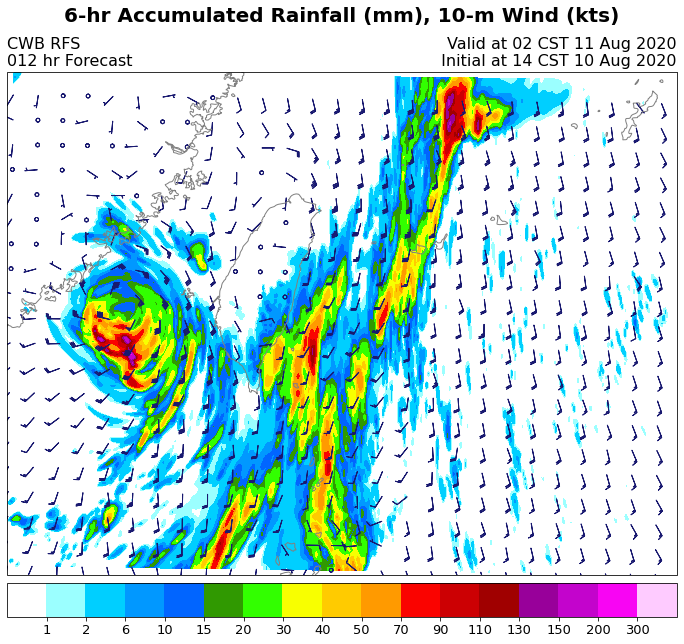

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

lambert = ccrs.LambertConformal(central_longitude=121.76013, \
       central_latitude=24.128498,standard_parallels=(10,40))

fig = plt.figure(figsize=(12,16))
axs = plt.axes(projection=lambert)
dataPath = "/content/data/My Drive/Datazone"
"""
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces',
    scale='10m',
    )
axs.add_feature(states_provinces,edgecolor='k',facecolor='none')
"""

shapeFilePath = dataPath + "/shpfile/ne_10m_admin_0_countries.shp"
shape_feature_plateCar = ShapelyFeature(shpreader.Reader(shapeFilePath).geometries(),\
            ccrs.PlateCarree(),facecolor='none',edgecolor='gray')
axs.add_feature(shape_feature_plateCar)

shape_feature_lambert = ShapelyFeature(shpreader.Reader(shapeFilePath).geometries(),\
            ccrs.LambertConformal(),facecolor='none',edgecolor='gray')


cwb_data=['None','#9BFFFF','#00CFFF','#0198FF','#0165FF','#309901','#32FF00','#F8FF00','#FFCB00',\
      '#FF9A00','#FA0300','#CC0003', '#A00000','#98009A','#C304CC','#F805F3','#FECBFF']
clevs = [0,1,2,6,10,15,20,30,40,50,70,90,110,130,150,200,300,400]
cmaps = mcolors.ListedColormap(cwb_data,'precipitation')
norms = mcolors.BoundaryNorm(clevs, cmaps.N)
ctf = plt.contourf(lon,lat,accRain6Hr,clevs,cmap=cmaps,norm=norms,transform=ccrs.PlateCarree())

cbar = plt.colorbar(ctf,orientation="horizontal",ticks=clevs[1:len(clevs)-1],pad=0.01)
cbar.ax.tick_params(labelsize=13)
plt.barbs(lon[::15,::15],lat[::15,::15],u10[::15,::15],v10[::15,::15],length=5,\
          color="midnightblue",transform=ccrs.PlateCarree())

plt.title("6-hr Accumulated Rainfall (mm), 10-m Wind (kts)\n\n",loc="center",fontsize=20,fontweight='bold')
plt.title("CWB RFS\n{} hr Forecast".format(fchr_str),loc="left",fontsize=16)
plt.title("Valid at {}\n Initial at {}".format(validTime_cst_str,initialTime_cst_str),loc="right",fontsize=16)
#ax.add_feature(shape_feature)

plt.show()

(673, 1158, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

finish draw:1
finish draw:2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


finish draw:3
finish draw:4


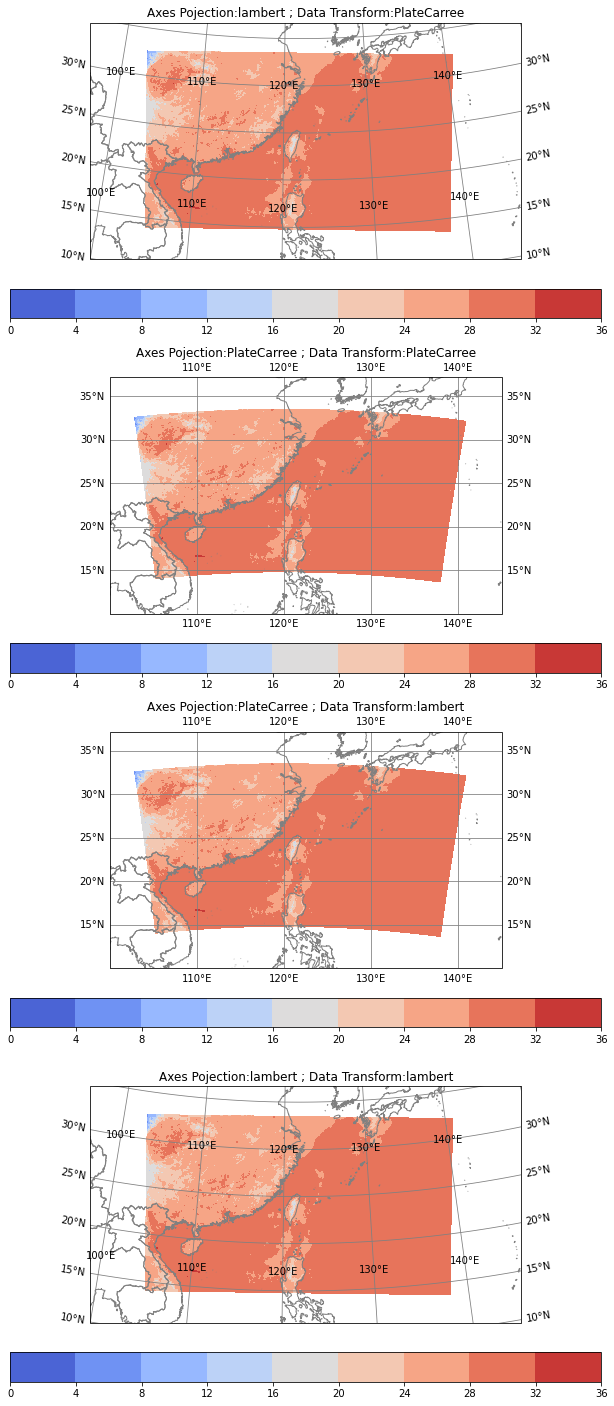

In [20]:
#lat = fnTau12.select()[0]["latitudes"].reshape(gridy,gridx)
#parameterName
surfTdict = fnTau12.select(parameterName="Temperature",typeOfLevel="heightAboveGround")[0]
surfT = surfTdict["values"] -273.15
latall = surfTdict["latitudes"].reshape(gridy,gridx)
lonall = surfTdict["longitudes"].reshape(gridy,gridx)

plt.figure(figsize=(20, 25))
projt = [ lambert, ccrs.PlateCarree(), ccrs.PlateCarree(),lambert] 
trans = [ ccrs.PlateCarree(), ccrs.PlateCarree(), lambert, lambert]
projtstr = ["lambert","PlateCarree","PlateCarree","lambert"]
transstr = ["PlateCarree","PlateCarree","lambert","lambert"]
#trans = {}
pics = 4
transform = lambert.transform_points(ccrs.PlateCarree(), lonall, latall)
print(transform.shape)
x = transform[:,: ,0]
y = transform[:,: ,1]
for picth in range(pics):
   plt.subplot(pics, 1, picth + 1, projection=projt[picth])
   plt.subplot(pics, 1, picth + 1, projection=projt[picth]).add_feature(shape_feature_plateCar)
   if transstr[picth] =="lambert":
     #lattrans = plt.subplot(pics, 1, picth + 1, projection=projt[picth]).transAxes.transform(latall)
     #lontrans = plt.subplot(pics, 1, picth + 1, projection=projt[picth]).transAxes.transform(lonall)
     contourf = plt.contourf(x,y,surfT,cmap="coolwarm",transform=trans[picth])
     plt.subplot(pics, 1, picth + 1, projection=projt[picth]).set_extent([100,145,10,35])
   else:
     contourf = plt.contourf(lonall,latall,surfT,cmap="coolwarm",transform=trans[picth])
     plt.subplot(pics, 1, picth + 1, projection=projt[picth]).set_extent([100,145,10,35])
   plt.subplot(pics, 1, picth + 1, projection=projt[picth]).gridlines(draw_labels=True,color='gray')
   plt.colorbar(contourf,orientation="horizontal",pad=0.1,fraction=0.1)
   plt.title("Axes Pojection:{} ; Data Transform:{}".format(projtstr[picth],transstr[picth]))
   print("finish draw:%i"%(picth+1))
plt.show()